In [51]:
import os
import numpy as np
import jax.numpy as jnp
import jax.random as random
from scipy.stats import gaussian_kde
# from rsnl.metrics import plot_and_save_coverage
from rsnl.examples.sir import calculate_summary_statistics, true_dgp, assumed_dgp
import matplotlib.pyplot as plt
import pickle as pkl
import arviz as az
import matplotlib.colors as mcolors
import pandas as pd

In [52]:
# Set the default font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['mathtext.fontset'] = 'cm'

In [53]:
seed = 4
rng_key = random.PRNGKey(seed)
rng_key, sub_key1, sub_key2 = random.split(rng_key, 3)
true_params = jnp.array([0.1, 0.15])
x_obs = true_dgp(sub_key2, *true_params)
x_obs = calculate_summary_statistics(x_obs)
print('x_obs', x_obs)


beta: 0.15000000596046448, gamma: 0.10000000149011612
x_obs [ 9.677356   8.457516  11.156182   4.75359    4.762174   0.9956981]


In [54]:
for i in range(10):
    rng_key, sub_key1, sub_key2 = random.split(rng_key, 3)
    print(calculate_summary_statistics(assumed_dgp(sub_key1, *true_params)))

beta: 0.15000000596046448, gamma: 0.10000000149011612
[ 9.677564    8.435976   11.06161     4.744932    4.762174    0.99969244]
beta: 0.15000000596046448, gamma: 0.10000000149011612
[ 9.677279   8.435324  11.0615     4.744932   4.762174   0.9996923]
beta: 0.15000000596046448, gamma: 0.10000000149011612
[ 9.677373   8.435538  11.061499   4.744932   4.762174   0.9996924]
beta: 0.15000000596046448, gamma: 0.10000000149011612
[ 9.67786     8.441205   11.061562    4.744932    4.762174    0.99969214]
beta: 0.15000000596046448, gamma: 0.10000000149011612
[ 9.677639    8.43689    11.061663    4.744932    4.762174    0.99969256]
beta: 0.15000000596046448, gamma: 0.10000000149011612
[ 9.677491    8.435365   11.061599    4.744932    4.762174    0.99969244]
beta: 0.15000000596046448, gamma: 0.10000000149011612
[ 9.677539   8.439734  11.061572   4.744932   4.762174   0.9996923]
beta: 0.15000000596046448, gamma: 0.10000000149011612
[ 9.677511   8.435068  11.061651   4.744932   4.762174   0.9996923]


In [55]:
with open("../res/sir/tmp_rsnl/rsnl/seed_4/thetas.pkl", "rb") as f:
    try:
        theta_draws_rsnl = jnp.array(pkl.load(f))
    except ModuleNotFoundError:
        theta_draws_rsnl = jnp.array(pd.read_pickle(f))

thetas_rsnl = jnp.concatenate(theta_draws_rsnl, axis=0)
thetas_rsnl = jnp.squeeze(thetas_rsnl)

with open("../res/sir/tmp_rsnl/rsnl/seed_4/adj_params.pkl", "rb") as f:
    try:
        adj_params = jnp.array(pkl.load(f))
    except ModuleNotFoundError:
        adj_params = jnp.array(pd.read_pickle(f))

adj_params = jnp.concatenate(adj_params, axis=0)

with open("../res/sir/snl/seed_4/thetas.pkl", "rb") as f:
    try:
        theta_draws_snl = jnp.array(pkl.load(f))
    except ModuleNotFoundError:
        theta_draws_snl = jnp.array(pd.read_pickle(f))

thetas_snl = jnp.concatenate(theta_draws_snl, axis=0)
thetas_snl = jnp.squeeze(thetas_snl)

with open("../res_rnpe/sir/seed_4/thetas.pkl", "rb") as f:
    thetas_rnpe = pkl.load(f)['posterior_samples']['RNPE']

# thetas_rnpe.at[:, [0, 1]].set(thetas_rnpe[:, [1, 0]])  # swap columns
# thetas_rnpe = jnp.concatenate(theta_draws_rnpe, axis=0)
# thetas_rnpe = jnp.squeeze(thetas_rnpe)  # TODO: wrong shape

In [56]:
thetas_rnpe.shape

(10000, 2)

In [57]:
rsnl_theta_plot = {}
snl_correct_theta_plot = {}
snl_theta_plot = {}
rnpe_theta_plot = {}
# TODO: complete RNPE plot here

for i in range(2):
    rsnl_theta_plot['theta' + str(i+1)] = thetas_rsnl[ :, i]
    snl_theta_plot['theta' + str(i+1)] = thetas_snl[:, i]
    rnpe_theta_plot['theta' + str(i+1)] = thetas_rnpe[:, 1-i]  # saved in reverse order

var_name_map = {}
reference_values = {}
labels = [r'$\eta$', r'$\beta$']
for ii, k in enumerate(rsnl_theta_plot):
    var_name_map[k] = labels[ii]
    reference_values[var_name_map[k]] = true_params[ii]  # why does ref_vals match labels and not data? ah well

In [71]:
axes

array([[<Axes: >, None],
       [<Axes: xlabel='$\\eta$', ylabel='$\\beta$'>, <Axes: >]],
      dtype=object)

/var/folders/_z/ms2f3nmn0bb7wk4py9_pz7900000gp/T/ipykernel_7752/1634323308.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


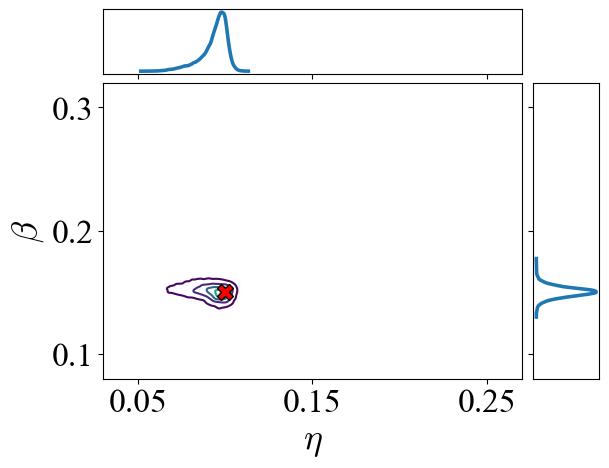

In [80]:
axes = az.plot_pair(rsnl_theta_plot,
             kind='kde',
             reference_values=reference_values,
             marginals=True,
             labeller=az.labels.MapLabeller(var_name_map=var_name_map),
             reference_values_kwargs={'color': 'red', 'marker': 'X', 'markersize': 12},
             kde_kwargs={'hdi_probs': [0.05, 0.25, 0.5, 0.75, 0.95],
                         'contour_kwargs': {"colors":None, "cmap":plt.cm.viridis},
                         'contourf_kwargs': {"alpha":0}},
             textsize=24,
            )

# Adjust the limits for the main bivariate joint plot directly
main_plot_ax = axes[1, 0]  # Identifying the main bivariate joint plot
main_plot_ax.set_xlim(0.03, 0.27)
main_plot_ax.set_ylim(0.08, 0.32)

# Setting ticks to start, middle, and end for x-axis
x_ticks = [0.05, (0.05 + 0.25) / 2, 0.25]
main_plot_ax.set_xticks(x_ticks)

# Setting ticks to start, middle, and end for y-axis
y_ticks = [0.1, (0.1 + 0.3) / 2, 0.3]
main_plot_ax.set_yticks(y_ticks)

# Adjust marginal plots' limits
# For eta parameter marginal (x-axis marginal)
if axes[0, 0] is not None:  # Ensure the axis exists
    axes[0, 0].set_xlim(0.03, 0.27)  # Adjust xlim for the eta parameter marginal

# For beta parameter marginal (y-axis marginal)
if axes[1, 1] is not None:  # Ensure the axis exists
    axes[1, 1].set_ylim(0.08, 0.32)  # Adjust ylim for the beta parameter marginal

plt.tight_layout()
plt.savefig("sir_theta_posterior.pdf", bbox_inches='tight')
# plt.xlabel(rf"$\theta_1$")

/var/folders/_z/ms2f3nmn0bb7wk4py9_pz7900000gp/T/ipykernel_7752/4040468935.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


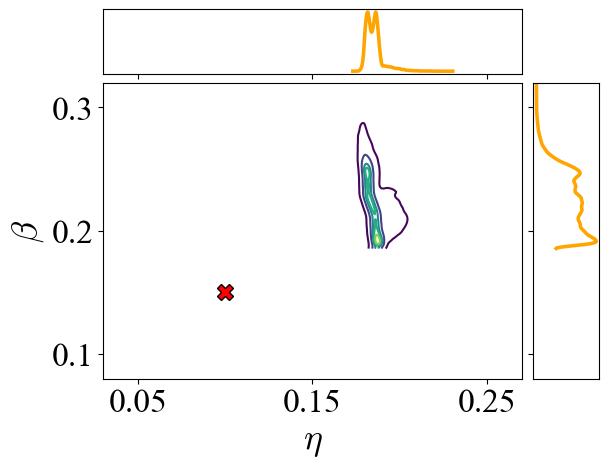

In [88]:
axes = az.plot_pair(snl_theta_plot,
             kind='kde',
             reference_values=reference_values,
             marginals=True,
             labeller=az.labels.MapLabeller(var_name_map=var_name_map),
             reference_values_kwargs={'color': 'red', 'marker': 'X', 'markersize': 12},
             kde_kwargs={'hdi_probs': [0.05, 0.25, 0.5, 0.75, 0.95],
                         'contour_kwargs': {"colors":None, "cmap":plt.cm.viridis},
                         'contourf_kwargs': {"alpha":0}},
             marginal_kwargs={'color': 'orange'},
             textsize=24,
            )

# Adjust the limits for the main bivariate joint plot directly
main_plot_ax = axes[1, 0]  # Identifying the main bivariate joint plot
main_plot_ax.set_xlim(0.03, 0.27)
main_plot_ax.set_ylim(0.08, 0.32)

# Setting ticks to start, middle, and end for x-axis
x_ticks = [0.05, (0.05 + 0.25) / 2, 0.25]
main_plot_ax.set_xticks(x_ticks)

# Setting ticks to start, middle, and end for y-axis
y_ticks = [0.1, (0.1 + 0.3) / 2, 0.3]
main_plot_ax.set_yticks(y_ticks)

# Adjust marginal plots' limits
# For eta parameter marginal (x-axis marginal)
if axes[0, 0] is not None:  # Ensure the axis exists
    axes[0, 0].set_xlim(0.03, 0.27)  # Adjust xlim for the eta parameter marginal

# For beta parameter marginal (y-axis marginal)
if axes[1, 1] is not None:  # Ensure the axis exists
    axes[1, 1].set_ylim(0.08, 0.32)  # Adjust ylim for the beta parameter marginal


plt.tight_layout()
plt.savefig("sir_snl_theta_posterior.pdf", bbox_inches='tight')
# plt.xlabel(rf"$\theta_1$")

/var/folders/_z/ms2f3nmn0bb7wk4py9_pz7900000gp/T/ipykernel_7752/578579455.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


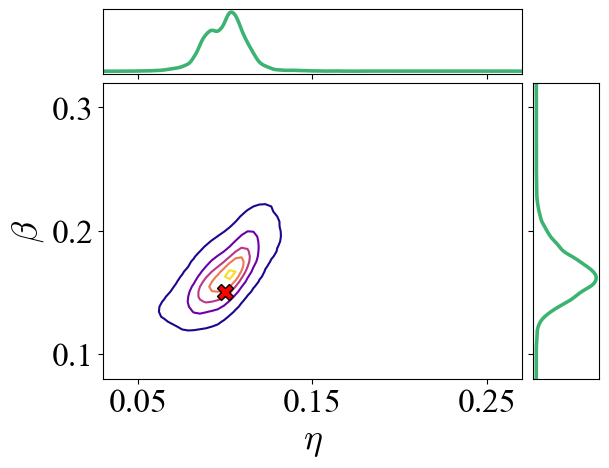

In [89]:
axes = az.plot_pair(rnpe_theta_plot,
             kind='kde',
             reference_values=reference_values,
             marginals=True,
             labeller=az.labels.MapLabeller(var_name_map=var_name_map),
             reference_values_kwargs={'color': 'red', 'marker': 'X', 'markersize': 12},
             kde_kwargs={'hdi_probs': [0.05, 0.25, 0.5, 0.75, 0.95],
                         'contour_kwargs': {"colors":None, "cmap":plt.cm.plasma},
                         'contourf_kwargs': {"alpha":0}},
             marginal_kwargs={'color': 'mediumseagreen'},
             textsize=24,
            )

# Adjust the limits for the main bivariate joint plot directly
main_plot_ax = axes[1, 0]  # Identifying the main bivariate joint plot
main_plot_ax.set_xlim(0.03, 0.27)
main_plot_ax.set_ylim(0.08, 0.32)

# Setting ticks to start, middle, and end for x-axis
x_ticks = [0.05, (0.05 + 0.25) / 2, 0.25]
main_plot_ax.set_xticks(x_ticks)

# Setting ticks to start, middle, and end for y-axis
y_ticks = [0.1, (0.1 + 0.3) / 2, 0.3]
main_plot_ax.set_yticks(y_ticks)

# Adjust marginal plots' limits
# For eta parameter marginal (x-axis marginal)
if axes[0, 0] is not None:  # Ensure the axis exists
    axes[0, 0].set_xlim(0.03, 0.27)  # Adjust xlim for the eta parameter marginal

# For beta parameter marginal (y-axis marginal)
if axes[1, 1] is not None:  # Ensure the axis exists
    axes[1, 1].set_ylim(0.08, 0.32)  # Adjust ylim for the beta parameter marginal


plt.tight_layout()
plt.savefig("sir_rnpe_theta_posterior.pdf", bbox_inches='tight')
# plt.xlabel(rf"$\theta_1$")

In [ ]:
# Set the default font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['mathtext.fontset'] = 'cm'


rng_key = random.PRNGKey(6)
prior_samples = random.laplace(rng_key, shape=(10000, 2))

for i in range(6):
    az.plot_dist(adj_params[:, i],
                 label='Posterior',
                 color='black')
    az.plot_dist(prior_samples[:, i],
                 color=mcolors.CSS4_COLORS['limegreen'],
                 plot_kwargs={'linestyle': 'dashed'},
                 label='Prior')

    plt.xlabel(f"$\gamma_{i+1}$", fontsize=25)
    plt.ylabel("Density", fontsize=25)
    plt.xlim([-10, 10])
    plt.xticks([-10, -5, 0, 5, 10], fontsize=25)
    plt.yticks(fontsize=25)
    plt.ylim(bottom=0)
    plt.legend(fontsize=25,
               loc='upper left',
               borderpad=0.1, labelspacing=0.1, handletextpad=0.1)

    plt.tight_layout()
    plt.savefig(f'sir_adj_param_{i+1}.pdf', bbox_inches='tight')
    plt.clf()